# Прогностическая модель рассеянного склероза

**Стэк:** *numpy, pandas, matplotlib, seaborn, tensorflow, sklearn.*

**Цель:** *написать прогностическую модель для определения вероятности рассеянного склероза. Где 0 - нет склероза, 1 - есть склероз. Наша цель написать модель, которая рекомендует обратится к врачу, не заменяет его. Поэтому 100% точности не требуется.*

In [ ]:
%%time
import matplotlib.pyplot as plt # библиотека для построения графиков и диаграмм
import numpy as np              # библиотека для научных вычислений и работы с массивами чисел
import os                       # библиотека для работы с файлами и каталогами операционной системы
import pandas as pd             # библиотека для работы с табличными данными
import pickle                   # Сохранение/загрузка словаря
import pydicom                  # библиотека для работы с DICOM-изображениями в медицине.
import random
import seaborn as sns           # график матрицы ошибок

from math import floor          # математическая библиотека Python
from PIL import Image           # библиотека для работы с изображениями
from sklearn.model_selection import train_test_split # Разбиение на тренировочную и тестовую выборки
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Матрица ошибок классификатора
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score # метрики для теста

import tensorflow as tf
# для создания сети
from tensorflow.keras.models import Sequential
# для создания слоев
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, GlobalAveragePooling2D, MaxPooling2D, Flatten, Dropout, SpatialDropout2D
# для работы с изображениями
from tensorflow.keras.preprocessing import image
# оптимизатор
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
# импортируем коллбэки
from keras.callbacks import  ReduceLROnPlateau,  EarlyStopping, ModelCheckpoint

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


CPU times: total: 0 ns
Wall time: 2 ms


Парсинг датасета: https://colab.research.google.com/drive/19lF7LtPIlx11xdBRI3fy-6B45pw0P_af

In [ ]:
%%time
# Загрузка объекта набора данных из файла
train_dataset = tf.data.Dataset.load('datasets_8_dimplom/train_dataset')
# Загрузка объекта набора данных из файла
val_dataset = tf.data.Dataset.load('datasets_8_dimplom/val_dataset')
# Загрузка объекта набора данных из файла
test_dataset = tf.data.Dataset.load('datasets_8_dimplom/test_dataset')


CPU times: total: 78.1 ms
Wall time: 77 ms


In [ ]:
x = 128
input_shape = (x, x, 1)

**План: Попробуем создать генератор моделей с простыми линейными архитектурами. Нужно сгенерировать архитектуру, обучить модель, протестировать на другой выборке, сравнить с другими и выбрать лучшую. Далее, лучшую модель до обучить.**

Напишем функции под каждую из этих задач. Сгенерируем и сравним с уже существующими моделями компьютерного зрения.

In [ ]:
def cv_architecture_generation(label = None, input_shape_size=input_shape):
    '''Генератор архитектур компьютерного зрения.'''
    def bloc_1(model, n=1):
        '''BatchNormalization помогает стабилизировать и ускорить процесс обучения за счет уменьшения внутреннего
        смещения ковариат, улучшения градиентного потока и обеспечения более высоких скоростей обучения.
        Нормализуя входные данные, это помогает сети быстрее сходиться и лучше обобщать невидимые данные.'''
        if random.choice([True,False,False,False]): model.add(BatchNormalization(name='BatchNormalization'))
        n+=1 # Контрольная сумма для создания последовательности слоев
        activation = random.choice(['relu','elu'])
        '''Слой Conv2D является основным строительным блоком в сверточных нейронных сетях для анализа изображений
        и выполняет операцию свертки с ядром (kernel) на входных данных.
        Conv2D обнаруживает локальные шаблоны и признаки в изображениях.'''
        model.add(Conv2D(neurons*n, (3, 3), activation=activation, input_shape=input_shape, name=f'{n}_bloc1_layer1_{activation}'))
        size = random.choice([3,5])
        '''Слой MaxPooling2D уменьшает размерность пространственных измерений входных данных, снижая их объем вычислений'''
        model.add(MaxPooling2D(pool_size=(size, size), name=f'{n}_bloc1_MaxPooling2Dsize_{size}_{size}'))
        if random.choice([True,False,False,False]):
            rc = random.choice([.2,.4])
            model.add(Dropout(rc, name=f'{n}_bloc1_Dropout_{rc}'))
        if random.choice([True,False,False]):
            '''SpatialDropout2D - это слой регуляризации, который случайным образом удаляет
            некоторые признаки на каждой изображении входных данных. Отличие SpatialDropout2D от Dropout заключается в том,
            что он удаляет не отдельные элементы, а целые каналы признаков в каждом изображении. Это позволяет сохранять
            пространственную структуру изображения и уменьшает вероятность возникновения артефактов после применения Dropout.'''
            rc = random.choice([.2,.4])
            model.add(SpatialDropout2D(rc, name=f'{n}_bloc1_SpatialDropout2D_{rc}'))
        # Всего 4*2*3*2*2*4*2=768 вариации
    def bloc_2(model, n):
        activation = random.choice(['relu','elu','sigmoid','tanh'])
        '''Dense используются для выполнения задачи классификации или регрессии.'''
        model.add(Dense(neurons//n, activation=activation, name=f'{n}_bloc2_Dense_{activation}'))
        if random.choice([True,False,False]):
            '''Dropout является методом регуляризации сети, который случайным образом отключает (обнуляет) некоторые нейроны
            во время обучения с определенной вероятностью. Это помогает предотвратить переобучение модели
            и повысить ее обобщающую способность'''
            rc = random.choice([.2,.4])
            model.add(Dropout(rc, name=f'{n}_bloc2_Dropout_{rc}'))
        # Всего 4*3*2=24 вариации

    # Общие параметры.
    input_shape = input_shape_size # Параметры входных данных.
    if label != None: model = Sequential(name=label) # Создаем модель. # 'generated_model'
    else: model = Sequential()
    n = np.random.randint(1,3) # Контрольная сумма для создания последовательности слоев. Например, повтора одного блока.
    '''n-число позволяет равномерно увеличивать число нейронов с каждым новым блоком до выравнивания и сокращением их после.
    Так же фиксирует порядковый номер блока в архитектуре.'''
    # Слои до выравнивающего слоя.
    neurons = random.choice([32,64]) # Число нейронов на старте. Будем увеличивать от блока к блоку.
    '''Число нейронов будет менятся от блока к блоку. Зависит от параметров внутри блока.'''
    [bloc_1(model,x) for x in range(n)] # bloc_1 - Слои до выравнивания. Генерируем случайное число блоков.
    # Выравнивающий слой.
    if random.choice([True,False]):
        '''Выравнивающий слой. Flatten() может быть более эффективным чем GlobalAveragePooling2D, так как он сохраняет
        пространственную информацию и позволяет полносвязным слоям использовать эту информацию
        для более точного прогнозирования классов.'''
        model.add(Flatten(name='Flatten'))
    else:
        '''GlobalAveragePooling2D - это слой пулинга, который усредняет значения признаков по всем пикселям каждого канала
        изображения. Он используется для уменьшения размерности выходных данных сверточной нейронной сети
        перед подачей их на полносвязный слой.'''
        model.add(GlobalAveragePooling2D(name=f'GlobalAveragePooling2D'))
    # Слои после выравнивающего слоя.
    neurons = neurons*n # Финальное число нейронов до выравнивания. Теперь будем уменьшать от блока к блоку.
    activation = random.choice(['relu','elu','sigmoid','tanh'])
    model.add(Dense(neurons, activation=activation,
                    name=f'first_Dense_{activation}')) # Первый слой после выравнивания.
    [bloc_2(model,x+n) for x in range(np.random.randint(1,3))] # bloc_2 - Слои после Flatten. Генерируем случайное число блоков.
    activation = random.choice(['sigmoid','softmax'])
    model.add(Dense(2, activation=activation, name=f'end_Dense_{activation}')) # Последний слой.
    # Всего 768*24*3*2*2*4*2*2=3,538,944 вариации
    model.build((None,input_shape[0], input_shape[1], input_shape[2]))
    return model

weight_label = 'diplom_weights_dataset8.h5' # название сохраненных весов для перезаписи.

def learn(model, batch_size=64, epochs=50, adam_num = 0.001):
    '''Функция обучения, компиляции и вывода результата.'''
    model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=Adam(adam_num), # Оптимизатор
                  metrics=['accuracy'])
    # Колбэки
    earlystop=EarlyStopping(monitor='val_loss',
                            min_delta=0,
                            patience=4,
                            verbose=1,
                            baseline=None,
                            restore_best_weights=True)

    reduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss',
                                          factor=0.6,
                                          patience=2,
                                          verbose=1)

    # Создаем коллбек сохранения весов
    checkpoint = ModelCheckpoint(weight_label, save_weights_only=True, save_best_only=True)

    # В любой момент в будущем мы можем загрузить сохраненные веса и продолжить обучение
    if os.path.isfile(weight_label):
        # Загружаем модель и ее веса из файла weights.h5
        model.load_weights(weight_label)

    store = model.fit(train_dataset,
                      shuffle=True,  # --------------------- перемешивание данных для равномерного обучения, соответствие экземпляра и метки сохраняется
                      batch_size=batch_size,  # -------------------- размер пакета, который обрабатывает нейронка перед одним изменением весов
                      epochs=epochs,  # ------------------------ epochs - количество эпох обучения
                      verbose=1,  # ------------------------ 0 - не визуализировать ход обучения, 1 - визуализировать
                      callbacks=[earlystop, reduceLROnPlateau, checkpoint],
                      validation_data=val_dataset)

    # Вывод графиков точности и ошибки
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    fig.suptitle('График процесса обучения модели')
    ax1.plot(store.history['accuracy'],
                   label='Доля верных ответов на обучающем наборе')
    ax1.plot(store.history['val_accuracy'],
                   label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(store.history['loss'],
                   label='Ошибка на обучающем наборе')
    ax2.plot(store.history['val_loss'],
                   label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

    return model

def test(model):
    '''Тестирование обученной модели. Визулазицаия матрицы-результата, итоговый счет.'''
    # Получаем прогнозы для val_ds
    y_pred = np.argmax(model.predict(test_dataset), axis=-1)
    # Получаем истинные метки для val_ds
    y_true = np.concatenate([y for x, y in test_dataset], axis=0)

    # проверим модель на эффективность. Выводим матрицу ошибок
    recall = ("recall: %.2f" % recall_score(y_true, y_pred))
    precision = ("precision: %.2f" % precision_score(y_true, y_pred))

    # Создаем фигуру с двумя подграфиками, расположенными рядом
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Строим вторую тепловую карту на втором подграфике
    cm = tf.math.confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[0])
    axes[0].set_title(f'Рассеянный склероз. Тест. {recall}, {precision}')

    # Строим первую тепловую карту на первом подграфике
    cm = confusion_matrix(np.argmax(tf.keras.utils.to_categorical(y_true.reshape(-1), 2), axis=1),
                          y_pred, normalize='true')
    sns.heatmap(cm, annot=True, ax=axes[1])
    final_score = round((cm[0][0]+cm[1][1])/2, 2)
    axes[1].set_title('Соотношение в процентах. Итоговая точность: {0}'.format(final_score))

    plt.show()
    return final_score

def auto_ml(n=1, batch_size=64, extra_education=1):
    '''n-число циклов генераций моделей, batch_size-размер батча, epochs-число эпох,
    extra_education - циклы дообучения лучшей модели.
    Функция генерации моделей, обучения, сравнения по результатам тестирования и отбор лучшей модели.'''
    best_score = [0] # Журнал прогресса.
    # Цикл генерации n-числа моделей.
    for _ in range(n):
        '''Для начала, удалим веса чужой модели, которые использовались для дообучения, что бы избежать ошибок
        с новой моделью.'''
        if os.path.exists(weight_label): os.remove(weight_label) # удаляем веса чужой модели
        try:
            model = cv_architecture_generation() # Генерируем архитектуру.
            model.summary() # Визуализация архитектуры.
            model = learn(model, batch_size, epochs=15) # Функция обучения, компиляции и вывода результата.
        except:
            model = cv_architecture_generation() # Генерируем архитектуру.
            model.summary() # Визуализация архитектуры.
            model = learn(model, batch_size, epochs=15) # Функция обучения, компиляции и вывода результата.
        test_score = test(model) # Тест на независимых данных.
        if test_score > best_score[-1]: # Если результат теста лучший прежних - сохранит модель.
            best_score.append(test_score) # Сохранить результат в журнал прогресса.
            best_model = model # Сохранить лучшую модель.
    print('\n\n\nПрогресс подбора моделей:', best_score[1:])
    print('Лучшая модель. Счет:', best_score[-1])
    best_model.summary() # Визуализация архитектуры.
    test(best_model) # Тест на независимых данных.
    print('\n\nОбучаем лучшую модель.')
    for _ in range(extra_education):
        if os.path.exists(weight_label): os.remove(weight_label) # удаляем веса чужой модели
        best_model = learn(best_model, batch_size, epochs=50) # Функция обучения, компиляции и вывода результата.
    best_model.save('AutoGen_ML_model.h5') # Сохранение
    print('Процесс завершен! Результат сохранен как AutoGen_ML_model.h5. Итоговая точность:', test(best_model)) # Тест на независимых данных.
    return best_model # Функция возвращает лучшую модель по итогам отбора и доп.обучения.


## Сгенерированная линейная модель
Сгенерируем 3 модели и обучим лучшую дополнительных 2 раза. При всем желании сделать больше, это займет слишком много времени. Нужно чем то ограничится. Время на одну модель не должно превышать 1 часа, а общее 8 часов. Пусть будет так. Быстрее может и не набрать целевую точность.

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 1_bloc1_layer1_relu (Conv2D  (None, 126, 126, 64)     640       
 )                                                               
                                                                 
 1_bloc1_SpatialDropout2D_0.  (None, 126, 126, 64)     0         
 2 (SpatialDropout2D)                                            
                                                                 
 1_bloc1_MaxPooling2Dsize_3_  (None, 42, 42, 64)       0         
 3 (MaxPooling2D)                                                
                                                                 
 BatchNormalization (BatchNo  (None, 42, 42, 64)       256       
 rmalization)                                                    
                                                                 
 2_bloc1_layer1_relu (Conv2D  (None, 40, 40, 128)     

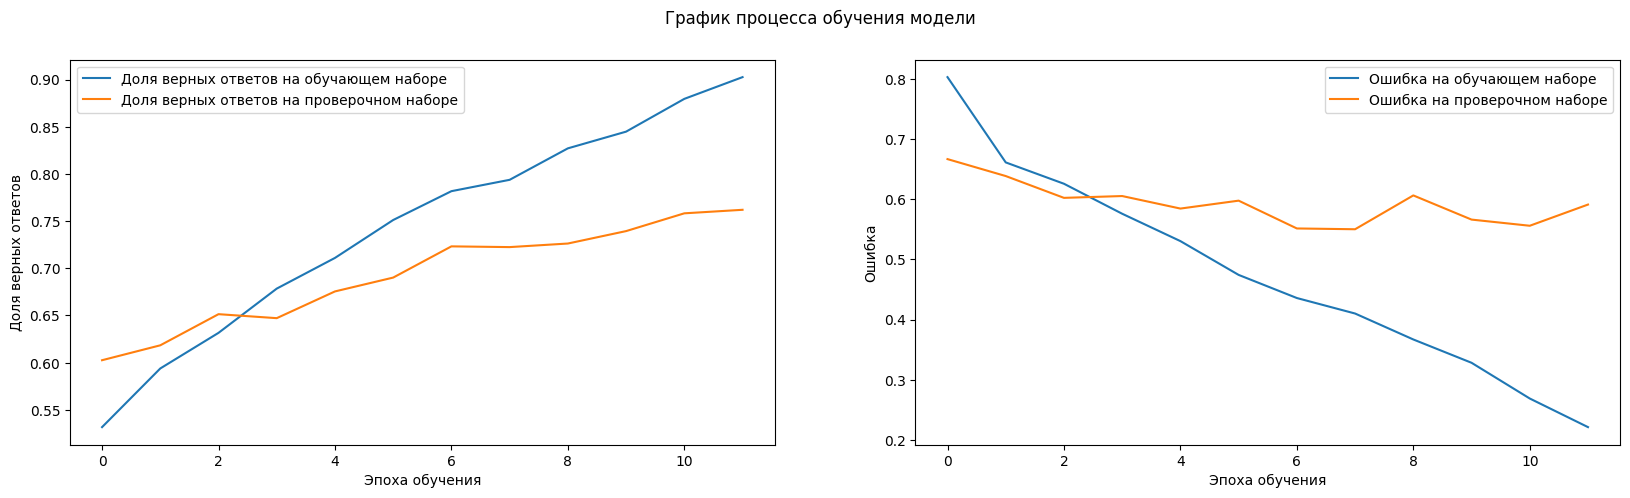

150/150 [==============================] - 12s 78ms/step


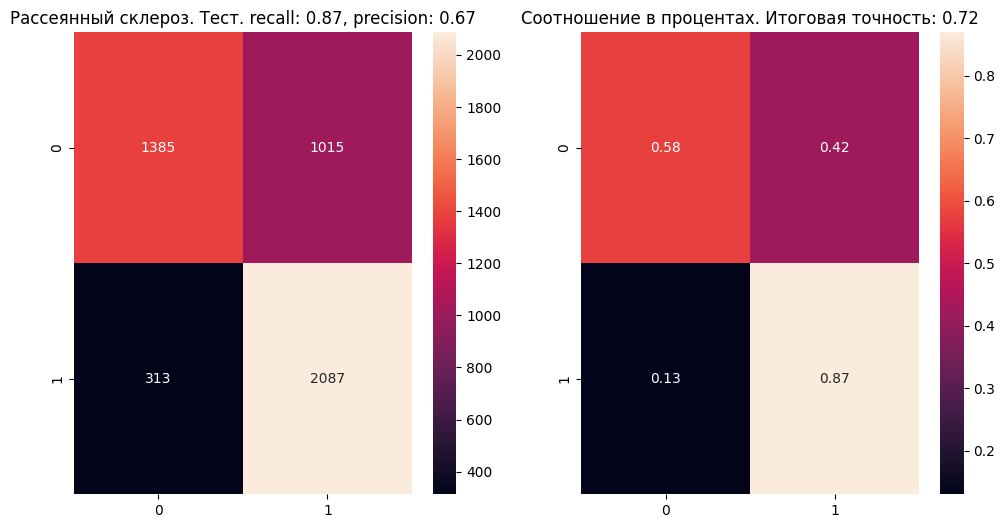

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 1_bloc1_layer1_elu (Conv2D)  (None, 126, 126, 64)     640       
                                                                 
 1_bloc1_SpatialDropout2D_0.  (None, 126, 126, 64)     0         
 2 (SpatialDropout2D)                                            
                                                                 
 1_bloc1_MaxPooling2Dsize_3_  (None, 42, 42, 64)       0         
 3 (MaxPooling2D)                                                
                                                                 
 GlobalAveragePooling2D (Glo  (None, 64)               0         
 balAveragePooling2D)                                            
                                                                 
 first_Dense_tanh (Dense)    (None, 64)                4160      
                                                      

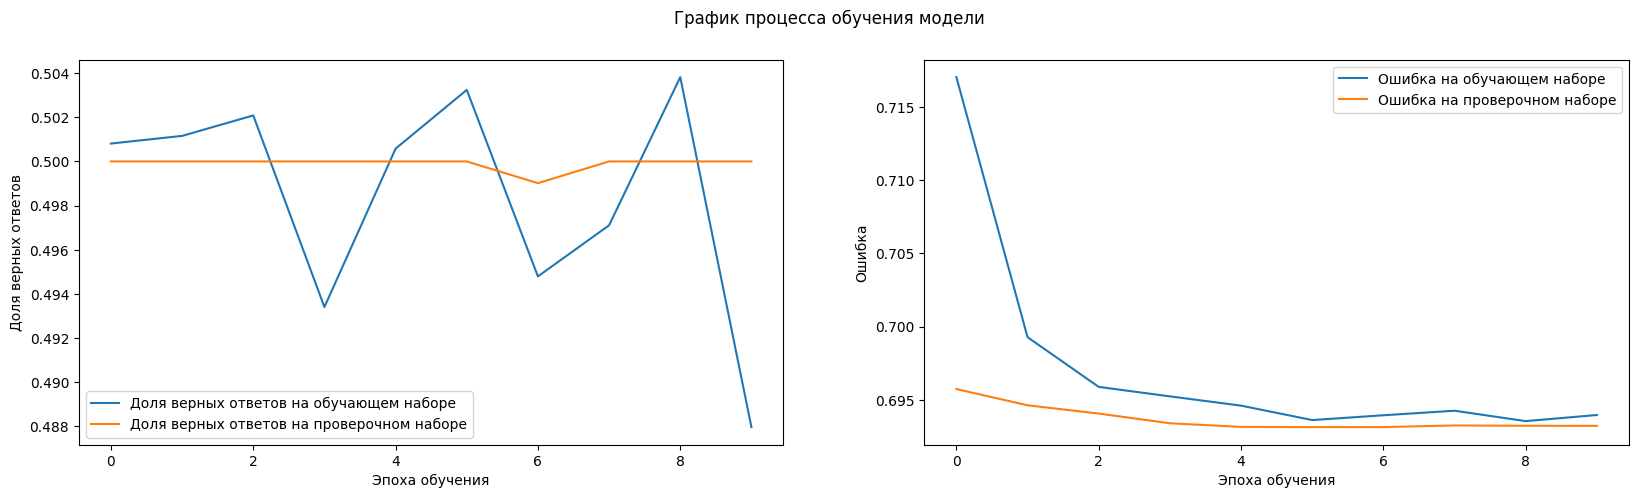

150/150 [==============================] - 7s 44ms/step


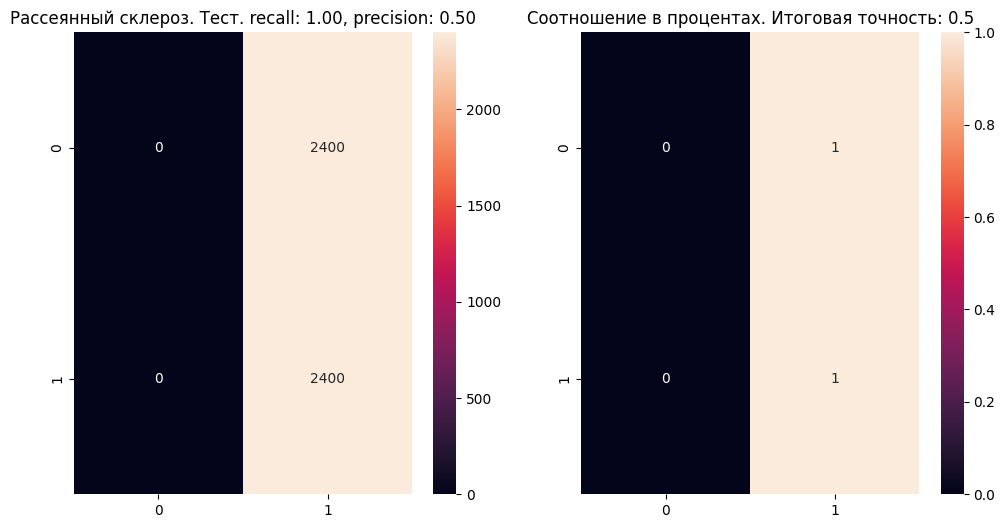

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 1_bloc1_layer1_elu (Conv2D)  (None, 126, 126, 32)     320       
                                                                 
 1_bloc1_MaxPooling2Dsize_5_  (None, 25, 25, 32)       0         
 5 (MaxPooling2D)                                                
                                                                 
 GlobalAveragePooling2D (Glo  (None, 32)               0         
 balAveragePooling2D)                                            
                                                                 
 first_Dense_relu (Dense)    (None, 32)                1056      
                                                                 
 1_bloc2_Dense_tanh (Dense)  (None, 32)                1056      
                                                                 
 1_bloc2_Dropout_0.4 (Dropou  (None, 32)              

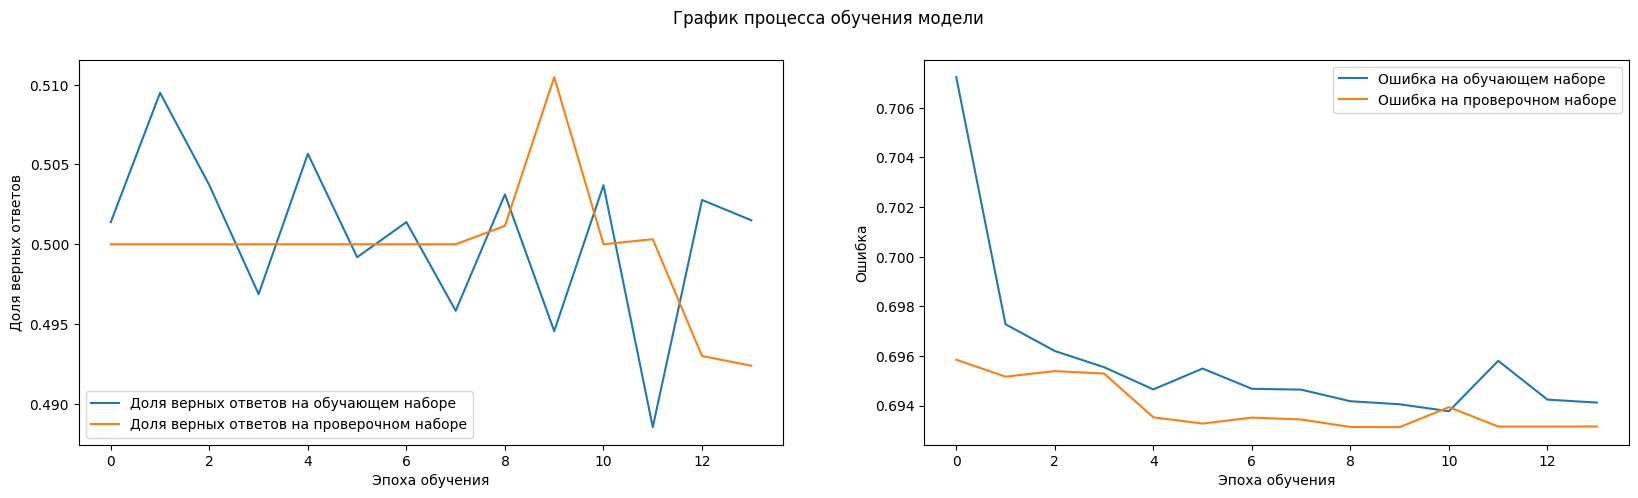

150/150 [==============================] - 3s 20ms/step


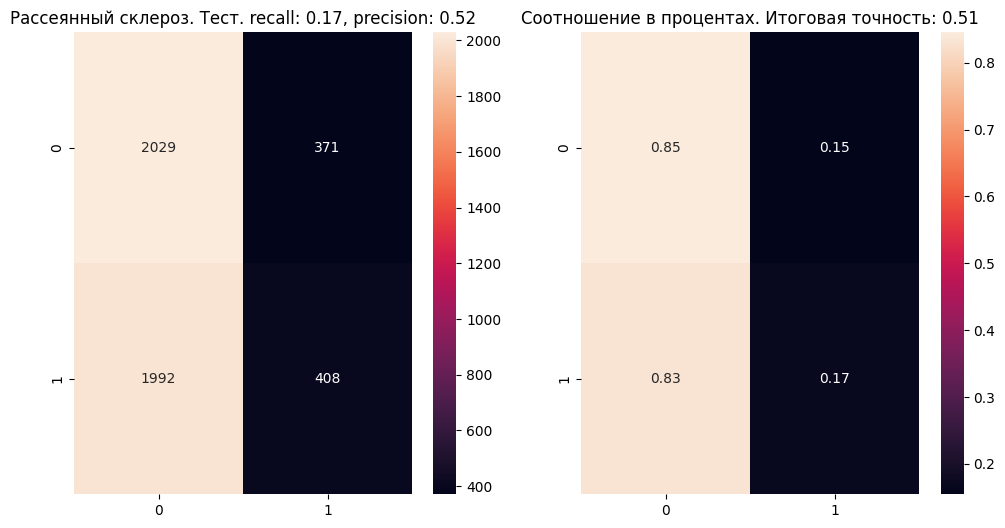




Прогресс подбора моделей: [0.72]
Лучшая модель. Счет: 0.72
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 1_bloc1_layer1_relu (Conv2D  (None, 126, 126, 64)     640       
 )                                                               
                                                                 
 1_bloc1_SpatialDropout2D_0.  (None, 126, 126, 64)     0         
 2 (SpatialDropout2D)                                            
                                                                 
 1_bloc1_MaxPooling2Dsize_3_  (None, 42, 42, 64)       0         
 3 (MaxPooling2D)                                                
                                                                 
 BatchNormalization (BatchNo  (None, 42, 42, 64)       256       
 rmalization)                                                    
                                                          

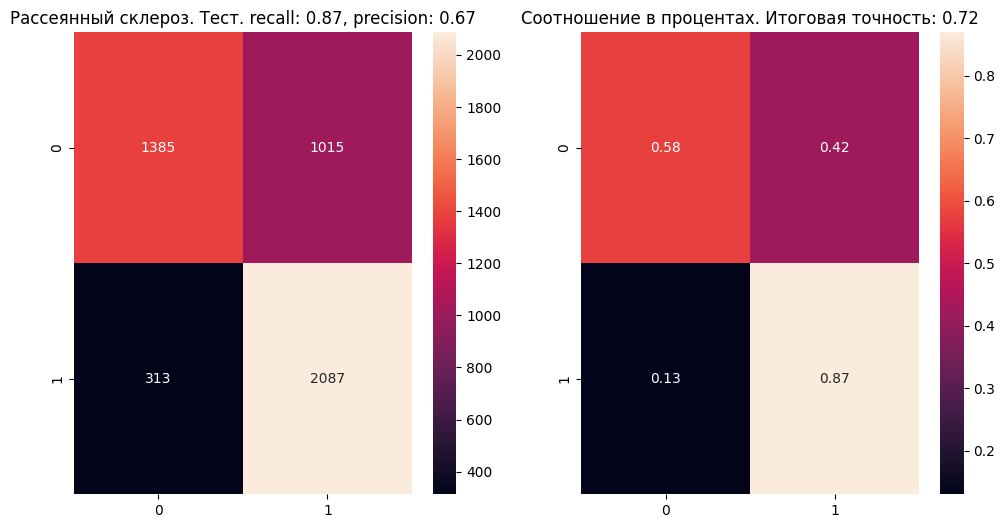



Обучаем лучшую модель.
Epoch 1/50
270/270 [==============================] - 130s 477ms/step - loss: 0.3545 - accuracy: 0.8295 - val_loss: 0.6483 - val_accuracy: 0.7230 - lr: 0.0010
Epoch 2/50
270/270 [==============================] - 128s 476ms/step - loss: 0.3240 - accuracy: 0.8462 - val_loss: 0.5678 - val_accuracy: 0.7403 - lr: 0.0010
Epoch 3/50
270/270 [==============================] - 128s 474ms/step - loss: 0.2779 - accuracy: 0.8716 - val_loss: 0.6497 - val_accuracy: 0.7359 - lr: 0.0010
Epoch 4/50
270/270 [==============================] - ETA: 0s - loss: 0.2577 - accuracy: 0.8875
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.
270/270 [==============================] - 128s 474ms/step - loss: 0.2577 - accuracy: 0.8875 - val_loss: 0.5834 - val_accuracy: 0.7591 - lr: 0.0010
Epoch 5/50
270/270 [==============================] - 128s 475ms/step - loss: 0.2006 - accuracy: 0.9141 - val_loss: 0.5902 - val_accuracy: 0.7682 - lr: 6.0000e-04
Epoch 6/50
270/

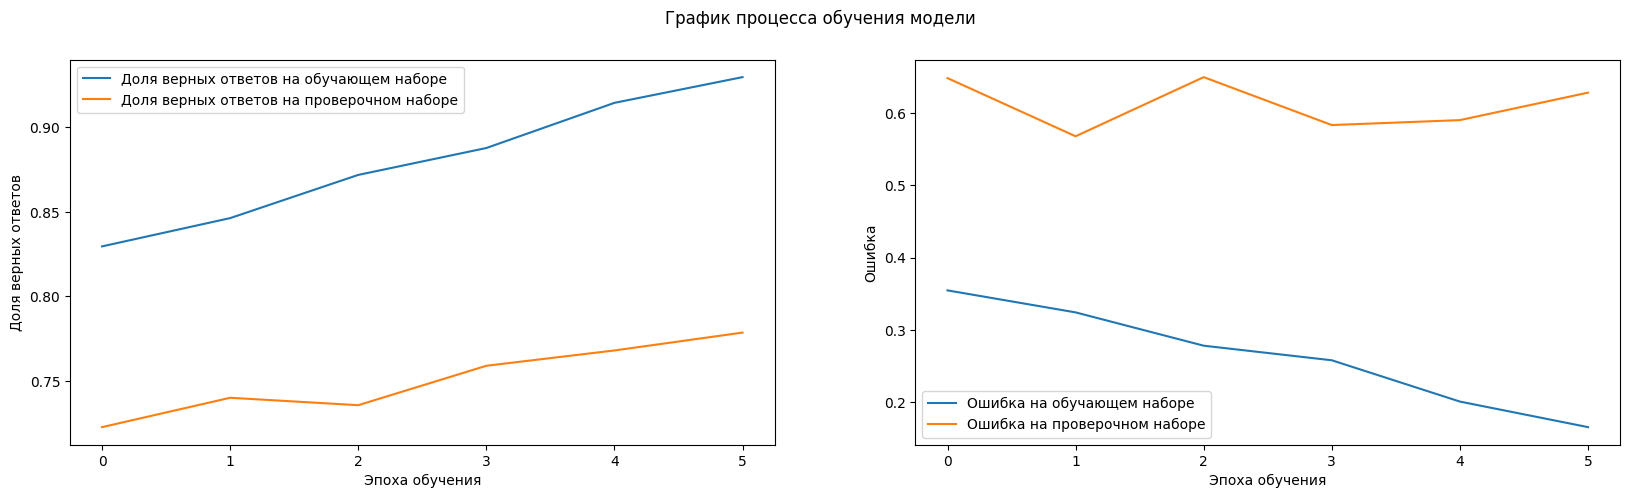

Epoch 1/50
270/270 [==============================] - 138s 502ms/step - loss: 0.2927 - accuracy: 0.8656 - val_loss: 0.5956 - val_accuracy: 0.7473 - lr: 0.0010
Epoch 2/50
270/270 [==============================] - 135s 501ms/step - loss: 0.2511 - accuracy: 0.8906 - val_loss: 0.5846 - val_accuracy: 0.7579 - lr: 0.0010
Epoch 3/50
270/270 [==============================] - 136s 504ms/step - loss: 0.2198 - accuracy: 0.9087 - val_loss: 0.6430 - val_accuracy: 0.7613 - lr: 0.0010
Epoch 4/50
270/270 [==============================] - ETA: 0s - loss: 0.2157 - accuracy: 0.9093
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.
270/270 [==============================] - 136s 505ms/step - loss: 0.2157 - accuracy: 0.9093 - val_loss: 0.6675 - val_accuracy: 0.7661 - lr: 0.0010
Epoch 5/50
270/270 [==============================] - 136s 506ms/step - loss: 0.1588 - accuracy: 0.9346 - val_loss: 0.6125 - val_accuracy: 0.7797 - lr: 6.0000e-04
Epoch 6/50
270/270 [====================

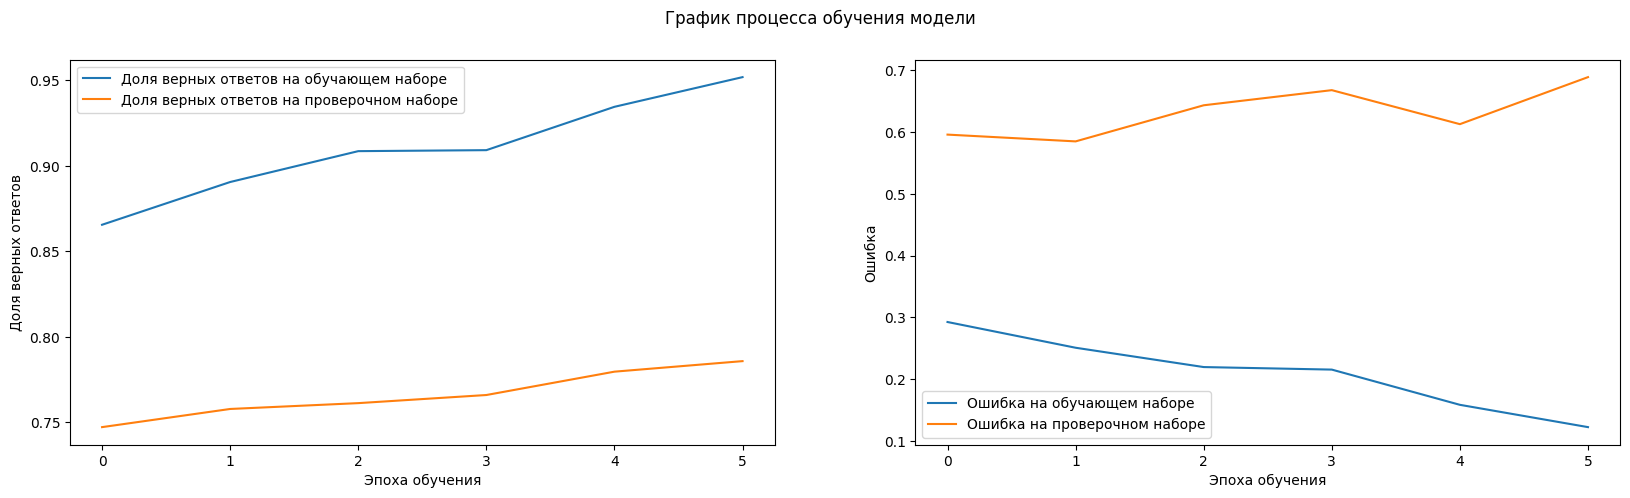

150/150 [==============================] - 10s 63ms/step


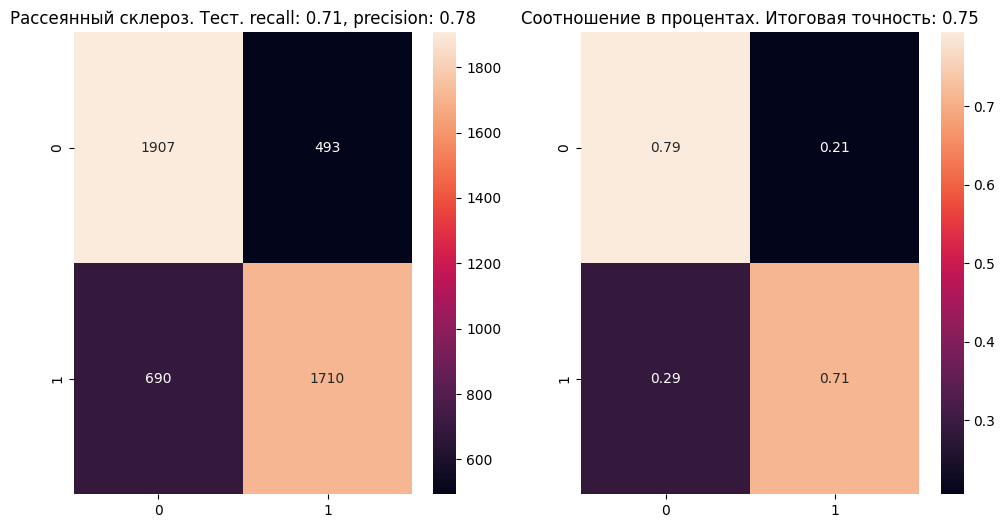

Процесс завершен! Результат сохранен как AutoGen_ML_model.h5. Итоговая точность: 0.75
CPU times: total: 10h 15min 31s
Wall time: 1h 23min 1s


In [ ]:
%%time
gen_model = auto_ml(n=3, extra_education=2)

Неплохо. Займемся дообучением модели. Но с большим значением Adam.

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 1_bloc1_layer1_relu (Conv2D  (None, 126, 126, 64)     640       
 )                                                               
                                                                 
 1_bloc1_SpatialDropout2D_0.  (None, 126, 126, 64)     0         
 2 (SpatialDropout2D)                                            
                                                                 
 1_bloc1_MaxPooling2Dsize_3_  (None, 42, 42, 64)       0         
 3 (MaxPooling2D)                                                
                                                                 
 BatchNormalization (BatchNo  (None, 42, 42, 64)       256       
 rmalization)                                                    
                                                                 
 2_bloc1_layer1_relu (Conv2D  (None, 40, 40, 128)     

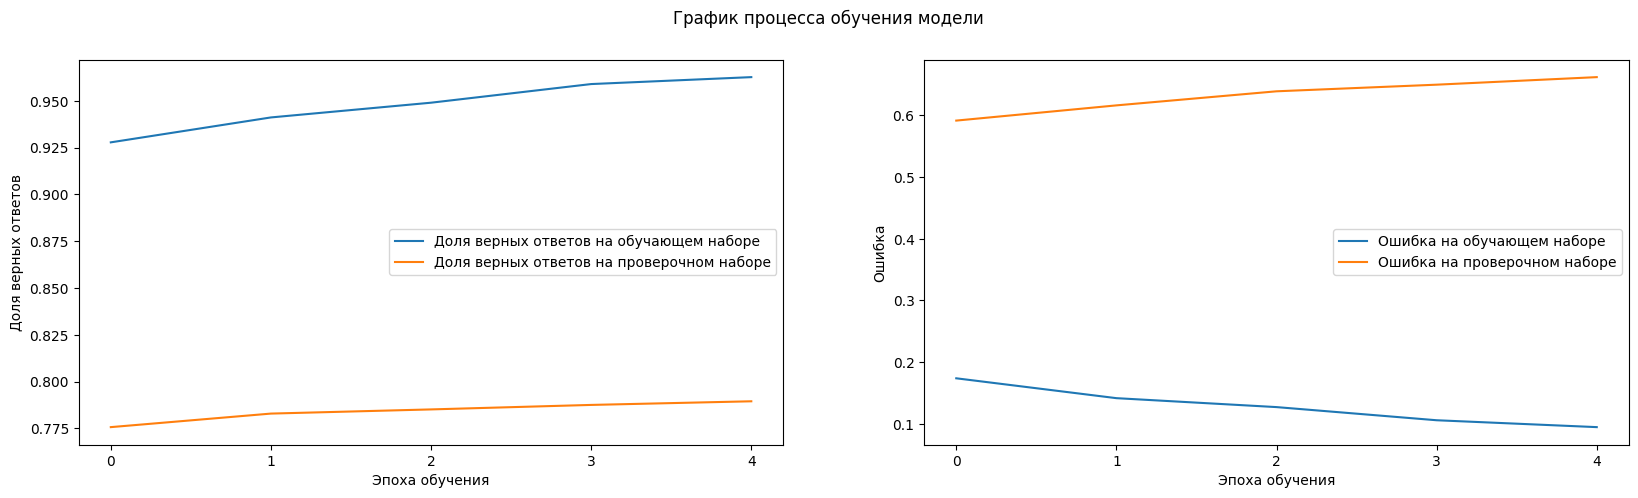

Epoch 1/50
270/270 [==============================] - 252s 928ms/step - loss: 0.1419 - accuracy: 0.9411 - val_loss: 0.6150 - val_accuracy: 0.7829 - lr: 1.0000e-04
Epoch 2/50
270/270 [==============================] - 247s 916ms/step - loss: 0.1229 - accuracy: 0.9483 - val_loss: 0.6454 - val_accuracy: 0.7839 - lr: 1.0000e-04
Epoch 3/50
270/270 [==============================] - ETA: 0s - loss: 0.1090 - accuracy: 0.9595
Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.
270/270 [==============================] - 236s 875ms/step - loss: 0.1090 - accuracy: 0.9595 - val_loss: 0.6583 - val_accuracy: 0.7875 - lr: 1.0000e-04
Epoch 4/50
270/270 [==============================] - 239s 888ms/step - loss: 0.0994 - accuracy: 0.9611 - val_loss: 0.6743 - val_accuracy: 0.7878 - lr: 6.0000e-05
Epoch 5/50
270/270 [==============================] - ETA: 0s - loss: 0.0916 - accuracy: 0.9637Restoring model weights from the end of the best epoch: 1.

Epoch 5: ReduceLROnPlateau reduc

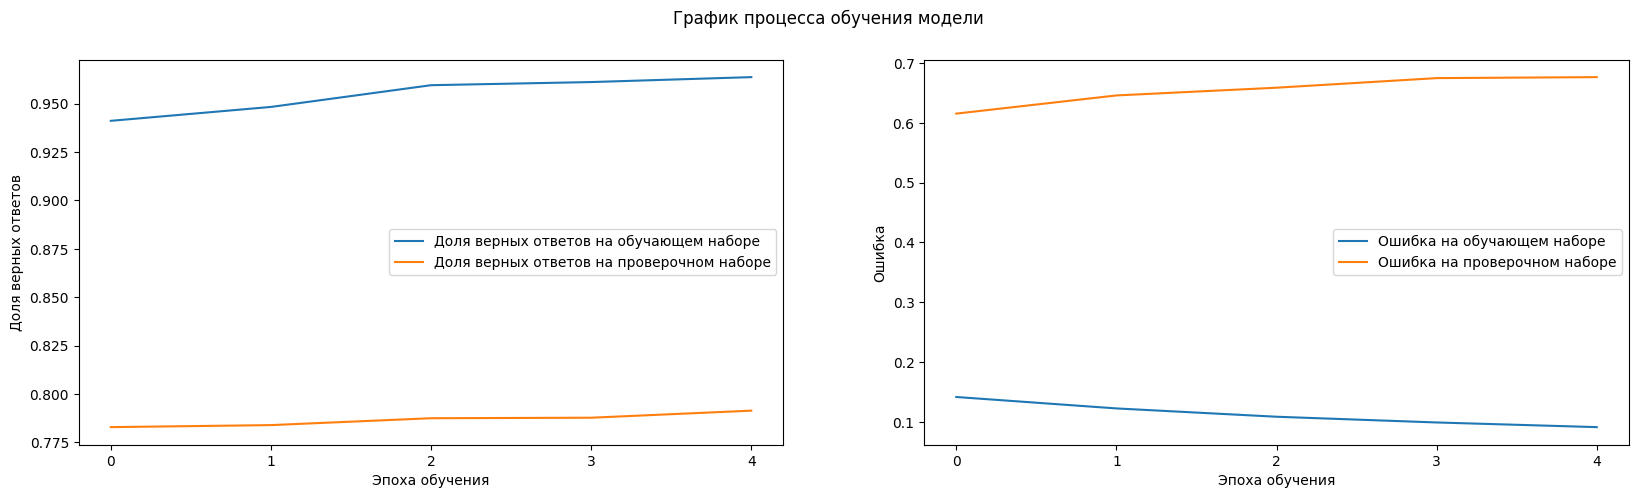

Epoch 1/50
270/270 [==============================] - 229s 846ms/step - loss: 0.1199 - accuracy: 0.9525 - val_loss: 0.6592 - val_accuracy: 0.7845 - lr: 1.0000e-04
Epoch 2/50
270/270 [==============================] - 231s 859ms/step - loss: 0.1128 - accuracy: 0.9522 - val_loss: 0.6613 - val_accuracy: 0.7880 - lr: 1.0000e-04
Epoch 3/50
270/270 [==============================] - ETA: 0s - loss: 0.1030 - accuracy: 0.9584
Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.
270/270 [==============================] - 228s 846ms/step - loss: 0.1030 - accuracy: 0.9584 - val_loss: 0.6725 - val_accuracy: 0.7888 - lr: 1.0000e-04
Epoch 4/50
270/270 [==============================] - 227s 843ms/step - loss: 0.0850 - accuracy: 0.9690 - val_loss: 0.6889 - val_accuracy: 0.7909 - lr: 6.0000e-05
Epoch 5/50
270/270 [==============================] - ETA: 0s - loss: 0.0806 - accuracy: 0.9699Restoring model weights from the end of the best epoch: 1.

Epoch 5: ReduceLROnPlateau reduc

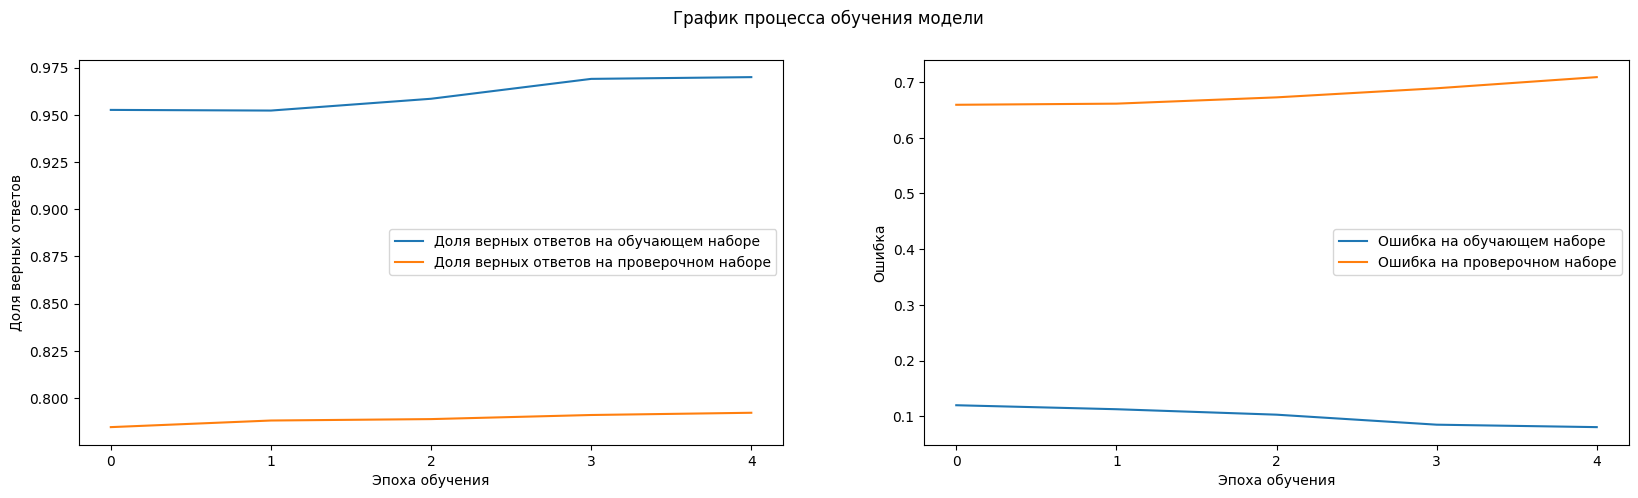

150/150 [==============================] - 17s 111ms/step


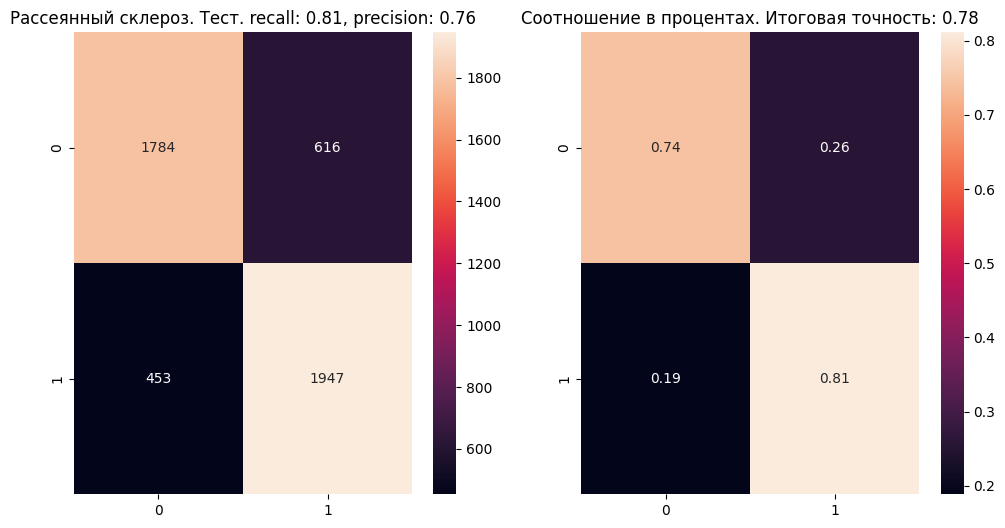

CPU times: total: 4h 45min 42s
Wall time: 1h 1min 48s


0.78

In [ ]:
%%time
gen_model = keras.models.load_model('AutoGen_ML_model.h5')
gen_model.summary() # Визуализация архитектуры.
for _ in range(3):
    gen_model = learn(gen_model, adam_num=0.0001)
test(gen_model)


## EfficientNet
Проверим на топовой архитектуре - EfficientNet, только версию по свежее и глубже возьмем. Это займет намного больше времени, зато точность будет выше.

https://paperswithcode.com/sota/image-classification-on-imagenet?dimension=Top%205%20Accuracy

<div>
    <img src="https://hsto.org/webt/k_/al/kx/k_alkxw1ztkaiv3ll6w26n2dwno.png" alt="альтернативный текст" title="заголовок изображения" style="float: left; margin-right: 20px">
</div>

<style>
    img {
        border: 1px solid black;
    }
</style>

Cause: could not parse the source code of <function <lambda> at 0x000001802DE508B0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x000001802DE508B0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x0000017F5CB7B910>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x0000017F5CB7B910>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x000001802DE53AC0>: no matching AST found among candida

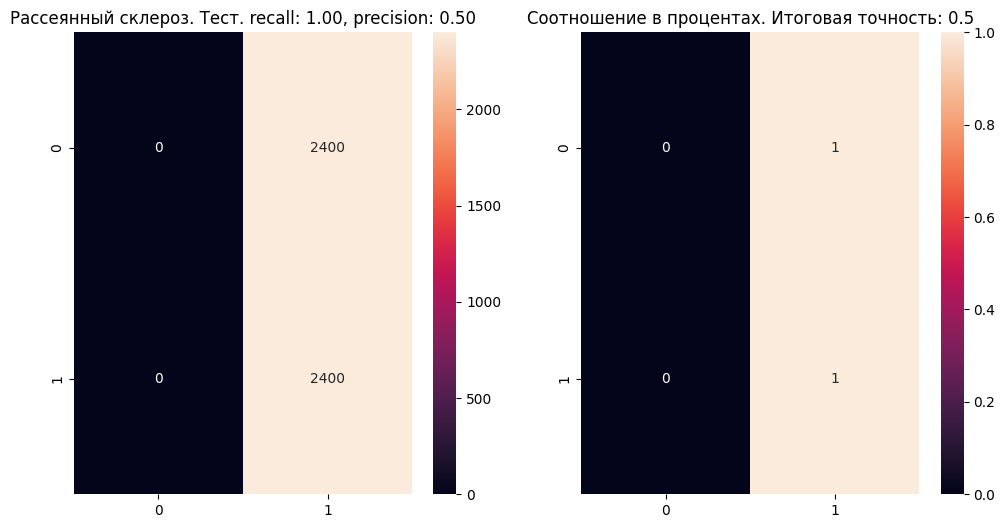

Итоговая точность: 0.5
CPU times: total: 2d 21h 20min 45s
Wall time: 12h 18min 5s


In [ ]:
%%time
from tensorflow.keras.applications.efficientnet import EfficientNetB7

# Преобразование данных для модели
train_data = train_dataset.map(lambda x, y: (x, y))
val_data = val_dataset.map(lambda x, y: (x, y))
test_data = test_dataset.map(lambda x, y: (x, y))

# Определение модели
EN_model = EfficientNetB7(input_shape=input_shape, include_top=True, weights=None, classes=2)
EN_model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=Adam(0.001), metrics=['accuracy'])

# Обучение модели на тренировочных данных и проверка на валидационных данных
EN_model.fit(train_data, epochs=9, validation_data=val_data)

print('Итоговая точность:', test(EN_model))

In [ ]:
EN_model.save('EN_model.h5') # Сохранение
print('Сохранено!')

Сохранено!


**EfficientNetB0**

Что-то, как-то совсем не впечатляет результат EfficientNetB7. Начнем с того, что это было слишком долго. Давайте еще раз попробуем EfficientNet, но самую упрощенную версию. Дадим второй шанс - поставим меньше эпох, повысим скорость оптимизатора.

Cause: could not parse the source code of <function <lambda> at 0x000001803D6AFE20>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x000001803D6AFE20>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x000001802DD348B0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x000001802DD348B0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x0000017F20063640>: no matching AST found among candida

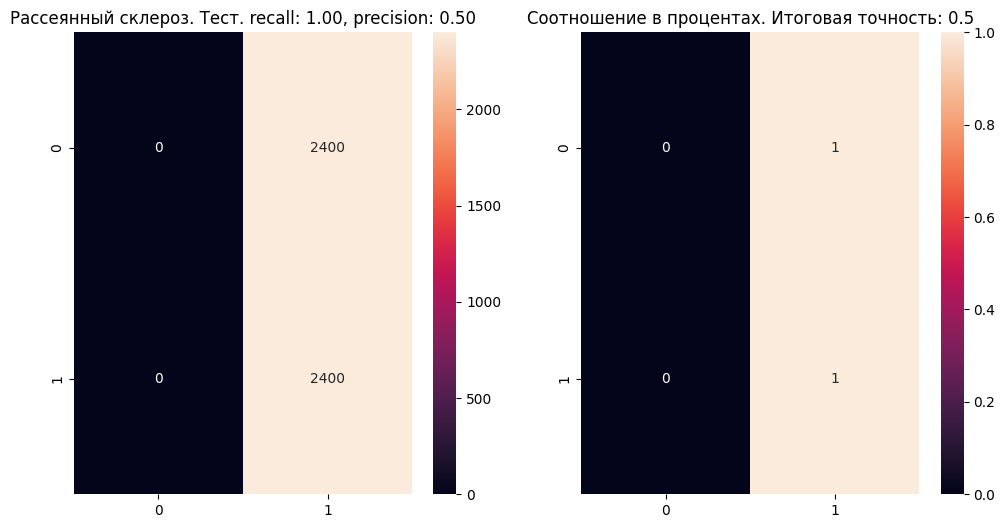

Итоговая точность: 0.5
Сохранено!
CPU times: total: 5h 46min 8s
Wall time: 1h 7min 20s


In [ ]:
%%time
from tensorflow.keras.applications.efficientnet import EfficientNetB0

# Определение модели
EN0_model = EfficientNetB0(input_shape=input_shape, include_top=True, weights=None, classes=2)
EN0_model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=Adam(0.01), metrics=['accuracy'])

# Обучение модели на тренировочных данных и проверка на валидационных данных
EN0_model.fit(train_data, epochs=5, validation_data=val_data)

print('Итоговая точность:', test(EN_model))

EN0_model.save('EN0_model.h5') # Сохранение
print('Сохранено!')

## Inception-ResNet-v2
Давайте еще одну из топа протестируем. Google не опубликовал Inception v4 на tensorflow, так что возьмем ближайший, ни чем не уступающий аналог 2017 года.

<div>
    <img src="https://hsto.org/getpro/habr/post_images/29b/f51/960/29bf5196085373528be31e27f2489bdd.jpg" alt="альтернативный текст" title="заголовок изображения" style="float: left; margin-right: 20px">
</div>

<style>
    img {
        border: 1px solid black;
    }
</style>

Epoch 1/9
270/270 [==============================] - 2259s 8s/step - loss: 0.7645 - accuracy: 0.5225 - val_loss: 0.6847 - val_accuracy: 0.5667
Epoch 2/9
270/270 [==============================] - 2195s 8s/step - loss: 0.6796 - accuracy: 0.5796 - val_loss: 0.6684 - val_accuracy: 0.5804
Epoch 3/9
270/270 [==============================] - 2211s 8s/step - loss: 0.6487 - accuracy: 0.6230 - val_loss: 0.6334 - val_accuracy: 0.6280
Epoch 4/9
270/270 [==============================] - 2252s 8s/step - loss: 0.6118 - accuracy: 0.6601 - val_loss: 0.9793 - val_accuracy: 0.5350
Epoch 5/9
270/270 [==============================] - 2202s 8s/step - loss: 0.5639 - accuracy: 0.6926 - val_loss: 0.6419 - val_accuracy: 0.6196
Epoch 6/9
270/270 [==============================] - 2170s 8s/step - loss: 0.5333 - accuracy: 0.7145 - val_loss: 0.6334 - val_accuracy: 0.6468
Epoch 7/9
270/270 [==============================] - 2188s 8s/step - loss: 0.4832 - accuracy: 0.7532 - val_loss: 0.6045 - val_accuracy: 0.6724

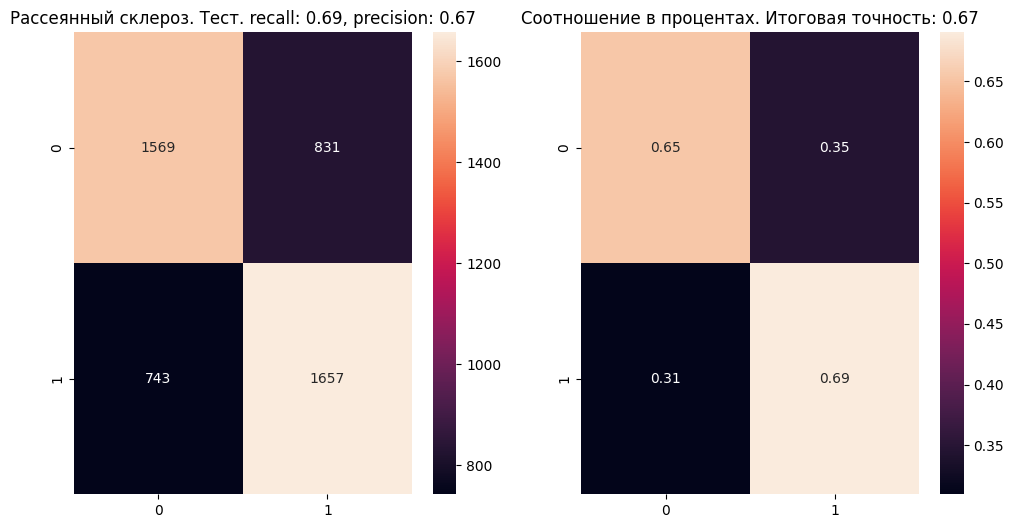

Итоговая точность: 0.67
CPU times: total: 1d 17min 21s
Wall time: 5h 33min 29s


In [ ]:
%%time
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

# Определение модели
IR_model = InceptionResNetV2(input_shape=input_shape, include_top=True, weights=None, classes=2)
IR_model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=Adam(0.001), metrics=['accuracy'])

# Обучение модели на тренировочных данных и проверка на валидационных данных
IR_model.fit(train_data, epochs=9, validation_data=val_data)

print('Итоговая точность:', test(IR_model))


In [ ]:
IR_model.save('IR_model.h5') # Сохранение
print('Сохранено!')

Сохранено!


# Вывод
Похоже, сгенерированные линейные модели, в целом, лучше справляются с задачей, чем предобученные нелинейные. В проекте main  мы подробнее разберем этот способ. В нем, мы достигли целевой точности 94%.
